# Behaviour cloning

This project is to experiment how to use neural network for regression where

* inputs: images captures when driving
* targets: how we control speed (throttle), steering and break

By fitting on training data, we expect that it can re-clone our behaviour. Let's load some module

In [1]:
# Load matplotib
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')  # emulates the aesthetics of ggplot (of R)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import cv2
import matplotlib.image as mpimg
import pandas as pd
import os

## Dataset
First, we try out the dataset provided by Udacity (can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)). The dataset contains

* images captured by center/left & right camera
* a csv file `driving_log.csv` that contains image files with corresponding `sterring angle, throttle, brake, speed`

Let's load & visualize some samples

In [10]:
def strip(text):
    try:
        return os.path.join('./data', text.strip())
    except AttributeError:
        return text

driving_log = pd.read_csv('./data/driving_log.csv', converters = {'left' : strip,
                                                                  'right' : strip,
                                                                  'center' : strip})

print(driving_log[:1])
print('\n----------------------------')
print('Number samples  {}'.format(driving_log.shape[0]))
print('Number of brake {}'.format(np.sum(driving_log['brake'])))
print(driving_log[['left', 'center','right']].values[0])

                                          center  \
0  ./data/IMG/center_2016_12_01_13_30_48_287.jpg   

                                          left  \
0  ./data/IMG/left_2016_12_01_13_30_48_287.jpg   

                                          right  steering  throttle  brake  \
0  ./data/IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0   

      speed  
0  22.14829  

----------------------------
Number samples  8036
Number of brake 15.82934781
['./data/IMG/left_2016_12_01_13_30_48_287.jpg'
 './data/IMG/center_2016_12_01_13_30_48_287.jpg'
 './data/IMG/right_2016_12_01_13_30_48_287.jpg']


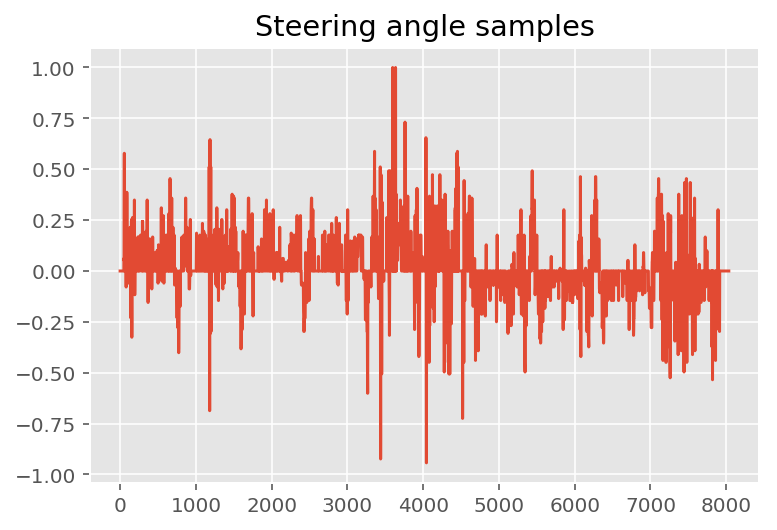

In [3]:
# check the steering angle through time
_ = plt.plot(driving_log.index, driving_log['steering'])
_ = plt.title('Steering angle samples')

min angle -0.9426954
max angle 1.0
number of positive 1900
number of negative 1775


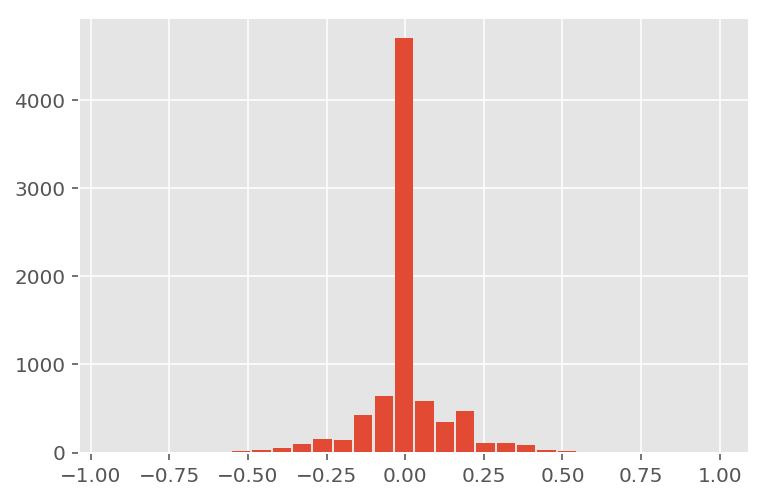

In [4]:
# check the distribution of steering angle
print
hist, bins = np.histogram(driving_log['steering'], 30)
width = 0.9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
_ = plt.bar(center, hist, align='center', width=width)
#plt.gca().set_yscale("log")
print('min angle {}'.format(np.min(driving_log['steering'])))
print('max angle {}'.format(np.max(driving_log['steering'])))
print('number of positive {}'.format(len(np.where(driving_log['steering'] > 0)[0])))
print('number of negative {}'.format(len(np.where(driving_log['steering'] < 0)[0])))

Looking at above data, we notice

* steering angle is mostly 0
* steering angle is skewed to the right (positive angle)

In [27]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')
            
def view_row(idx, data = driving_log, figsize=(20,4)):
    fig, axes = plt.subplots(figsize= figsize, nrows=1, ncols=3, sharey=True, sharex=True)
    img_cols = ['left', 'center', 'right']
    for i, ax in enumerate(axes.flatten()):
        img = mpimg.imread(data[img_cols[i]][idx])
        h, w = img.shape[:2]
        # add a line represents speed + steering
        if i == 1:
            angle = data['steering'][idx]
            speed = data['speed'][idx]*3
            x = int(w/2 + np.sin(angle) * speed)
            y = int(h - np.cos(angle) * speed)
            cv2.line(img,(int(w/2),int(h)),(x, y),(0,255,0),thickness=4)
            
        show_img(img, img_cols[i], ax)
        

Let's visualize some images for training dataset

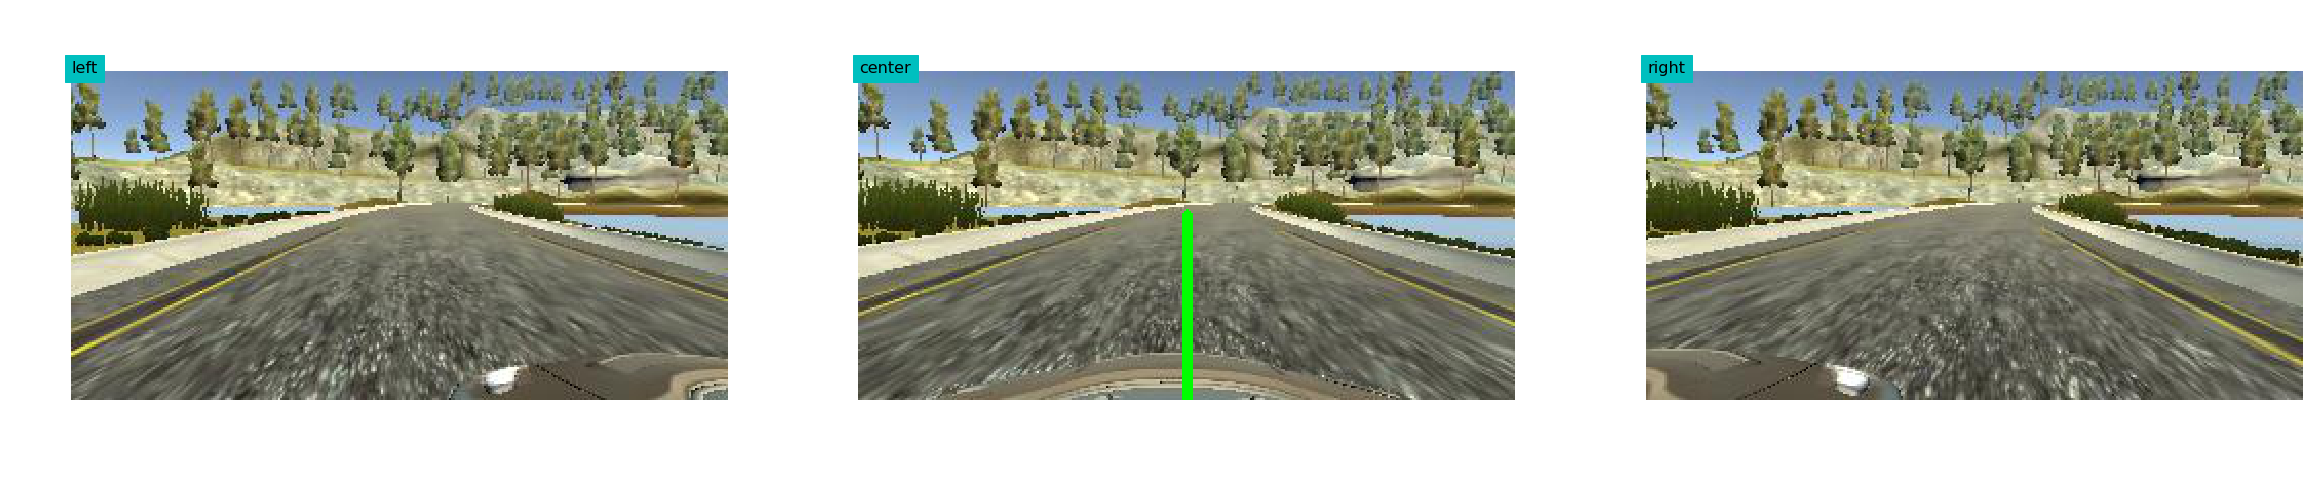

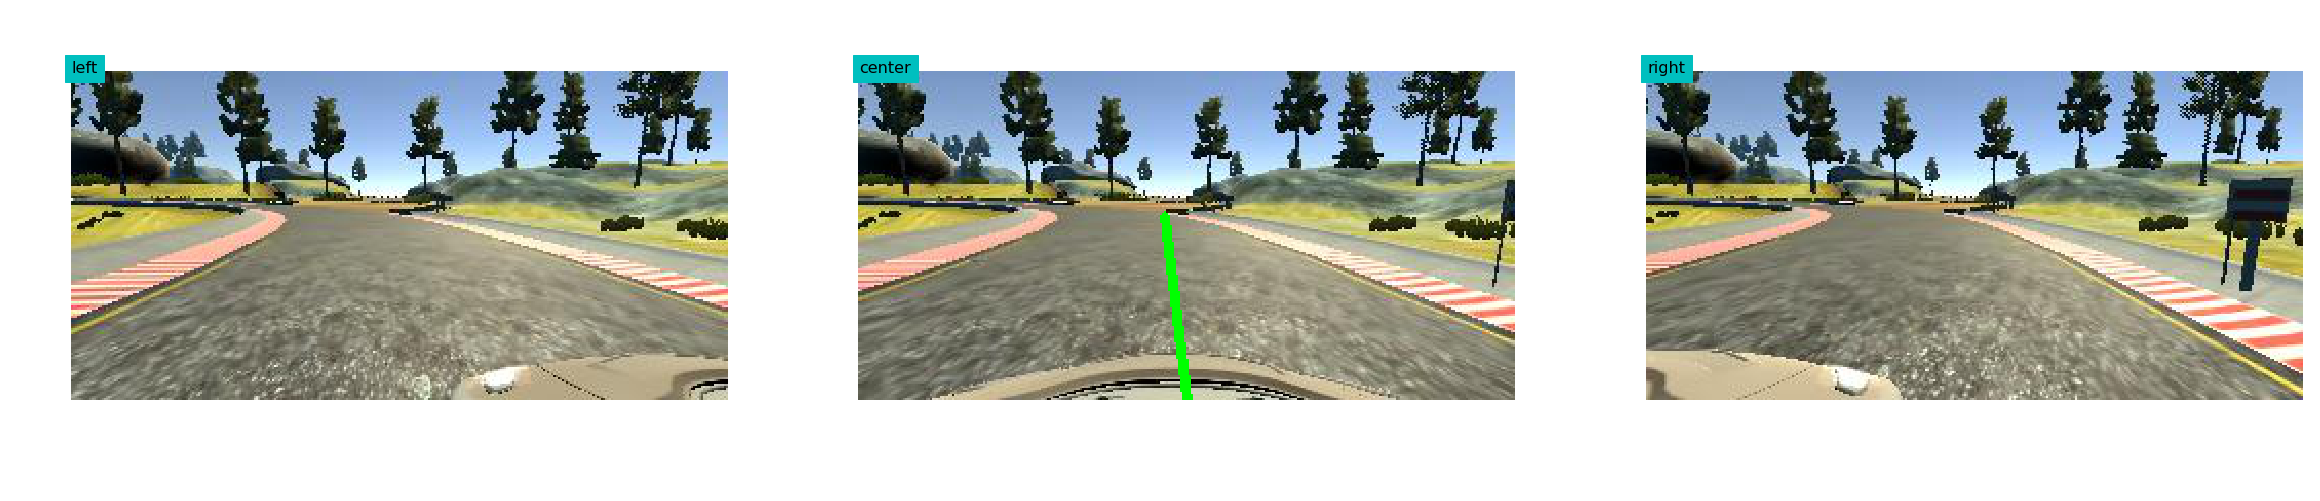

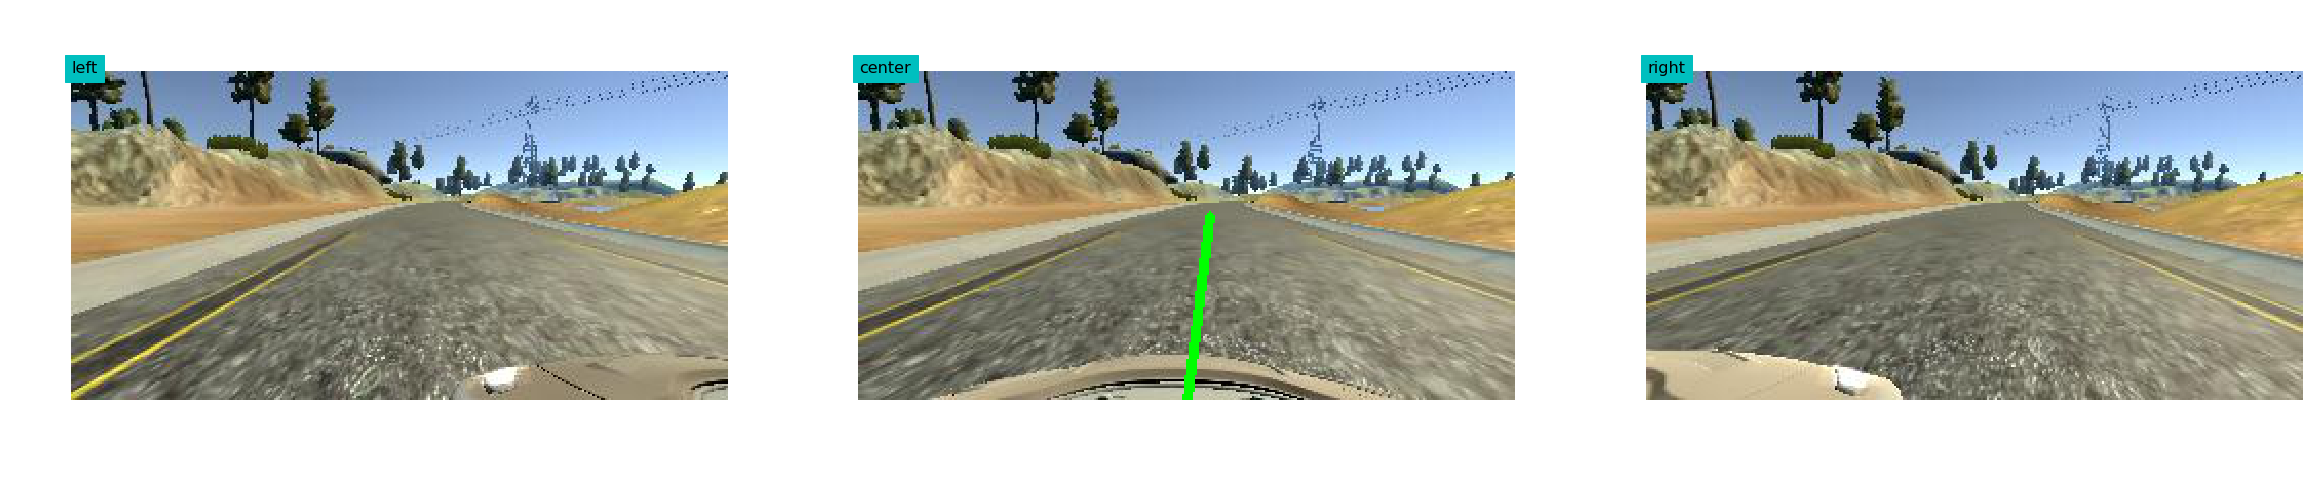

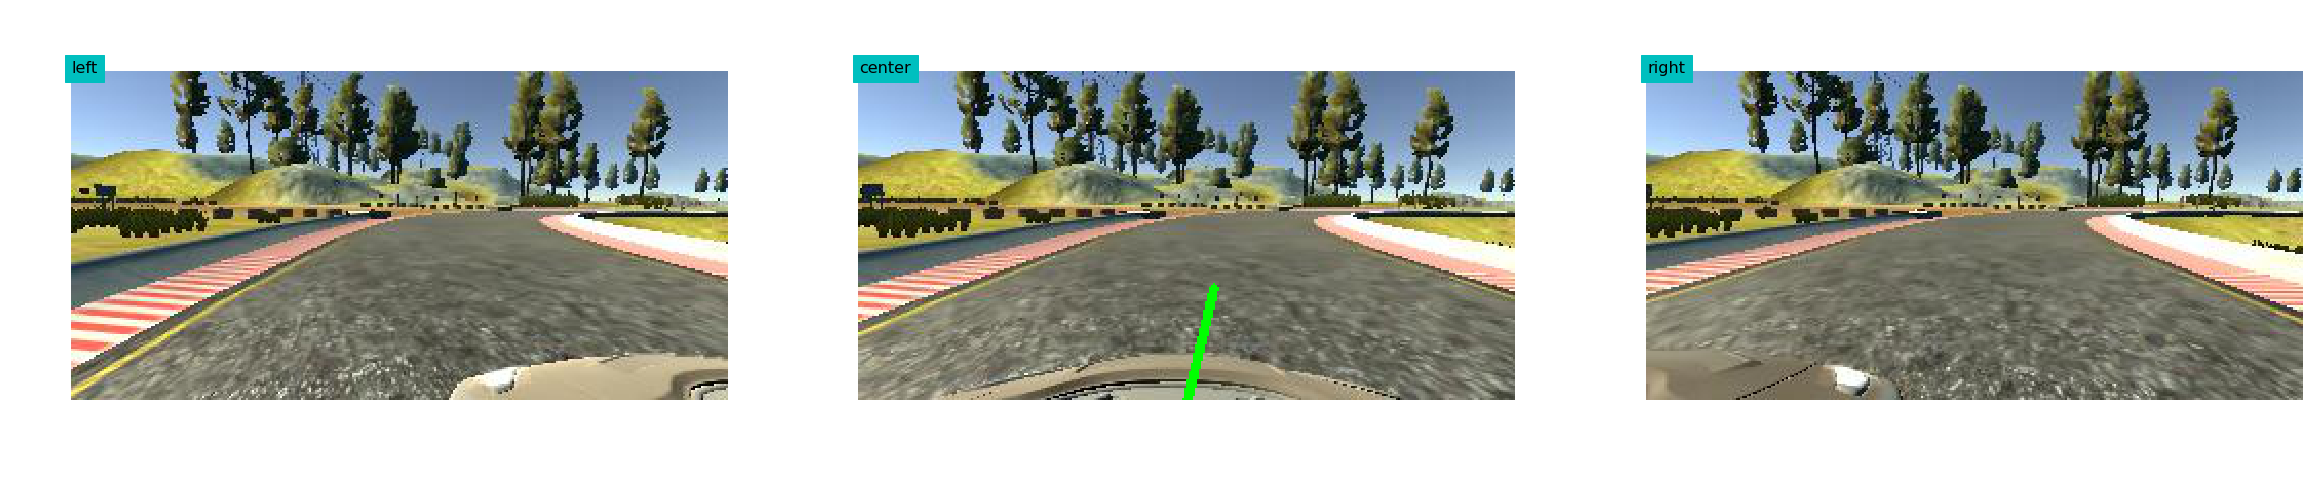

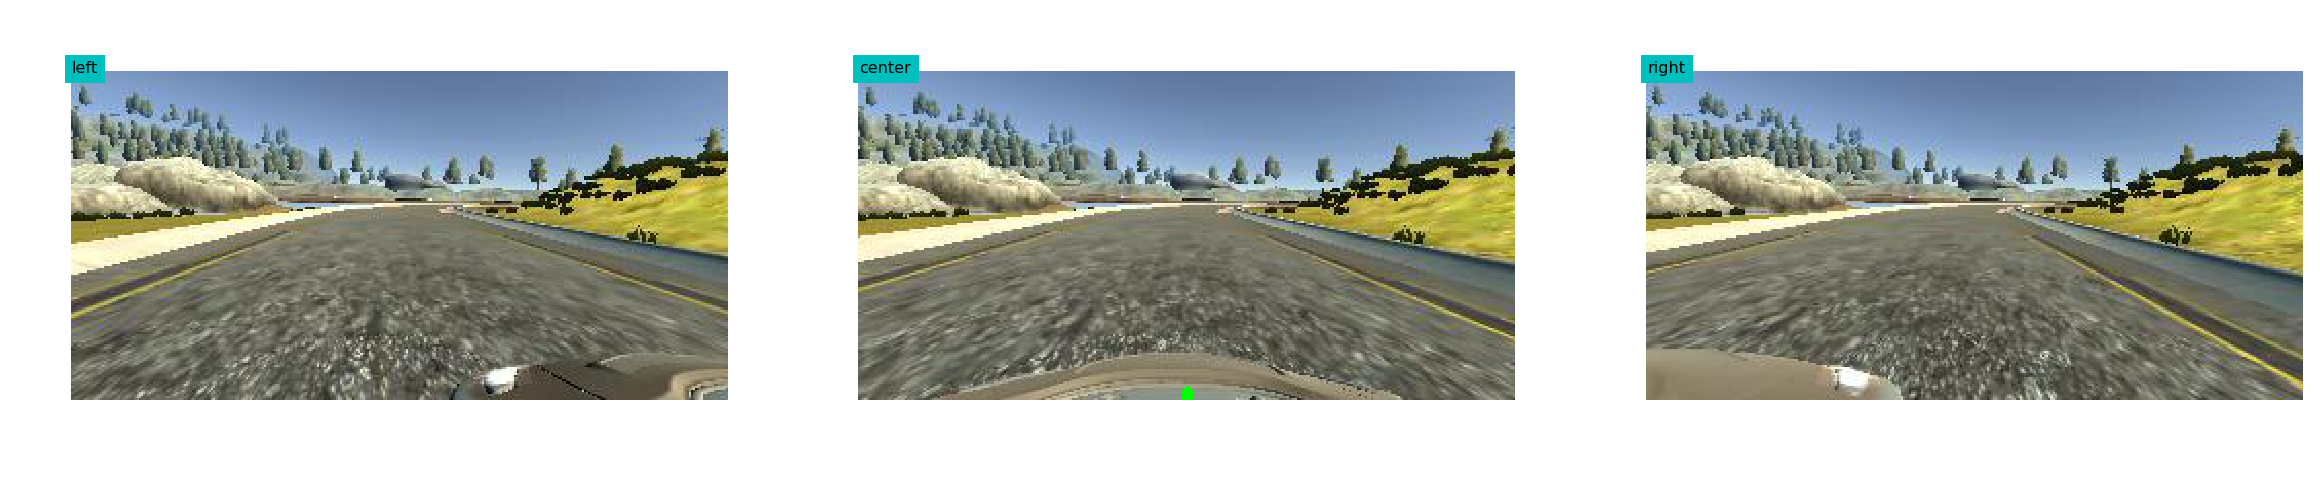

In [12]:
for i in range(5):
    view_row(np.random.randint(driving_log.shape[0]))

## Data preprocessing

### Region of interest
Looking at input images, we notice

* the top of images contains tree/sky and the bottom of image contain a part of our car => this is not helpful so we should crop it out (this is also suggested in the project page)

In [13]:
from keras.models import Sequential, Model
from keras.layers import Cropping2D
import cv2

# set up cropping2D layer
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), 
                     input_shape=(160,320,3)))

# following ref from
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
# one can visualize Cropping2D as following
from keras import backend as K
get_crop_img = K.function([model.layers[0].input],
                          [model.layers[0].output])

def view_crop_img(idx, data = driving_log, figsize=(20,8)):
    fig, axes = plt.subplots(figsize=figsize, 
                             nrows=2, ncols=3, 
                             sharey=True, sharex=True)
    
    all_axes = axes.flatten()
    
    img_cols = ['left', 'center', 'right']
    img_ins = []
    for i in range(3):
        img = mpimg.imread(data[img_cols[i]][idx])
        img_ins.append(img)
    img_ins = np.array(img_ins)
    
    # output of crop_img is double => need to convert to uint8 to be displayed correctly
    # note that we have
    # img_ins[i][50:140,:,:] = img_crops[i]
    img_crops = get_crop_img([img_ins])[0].astype(np.uint8)
    for i in range(3):
        show_img(img_ins[i], img_cols[i], all_axes[i])
        show_img(img_crops[i], img_cols[i] + '_crop', all_axes[i+3])

Using TensorFlow backend.


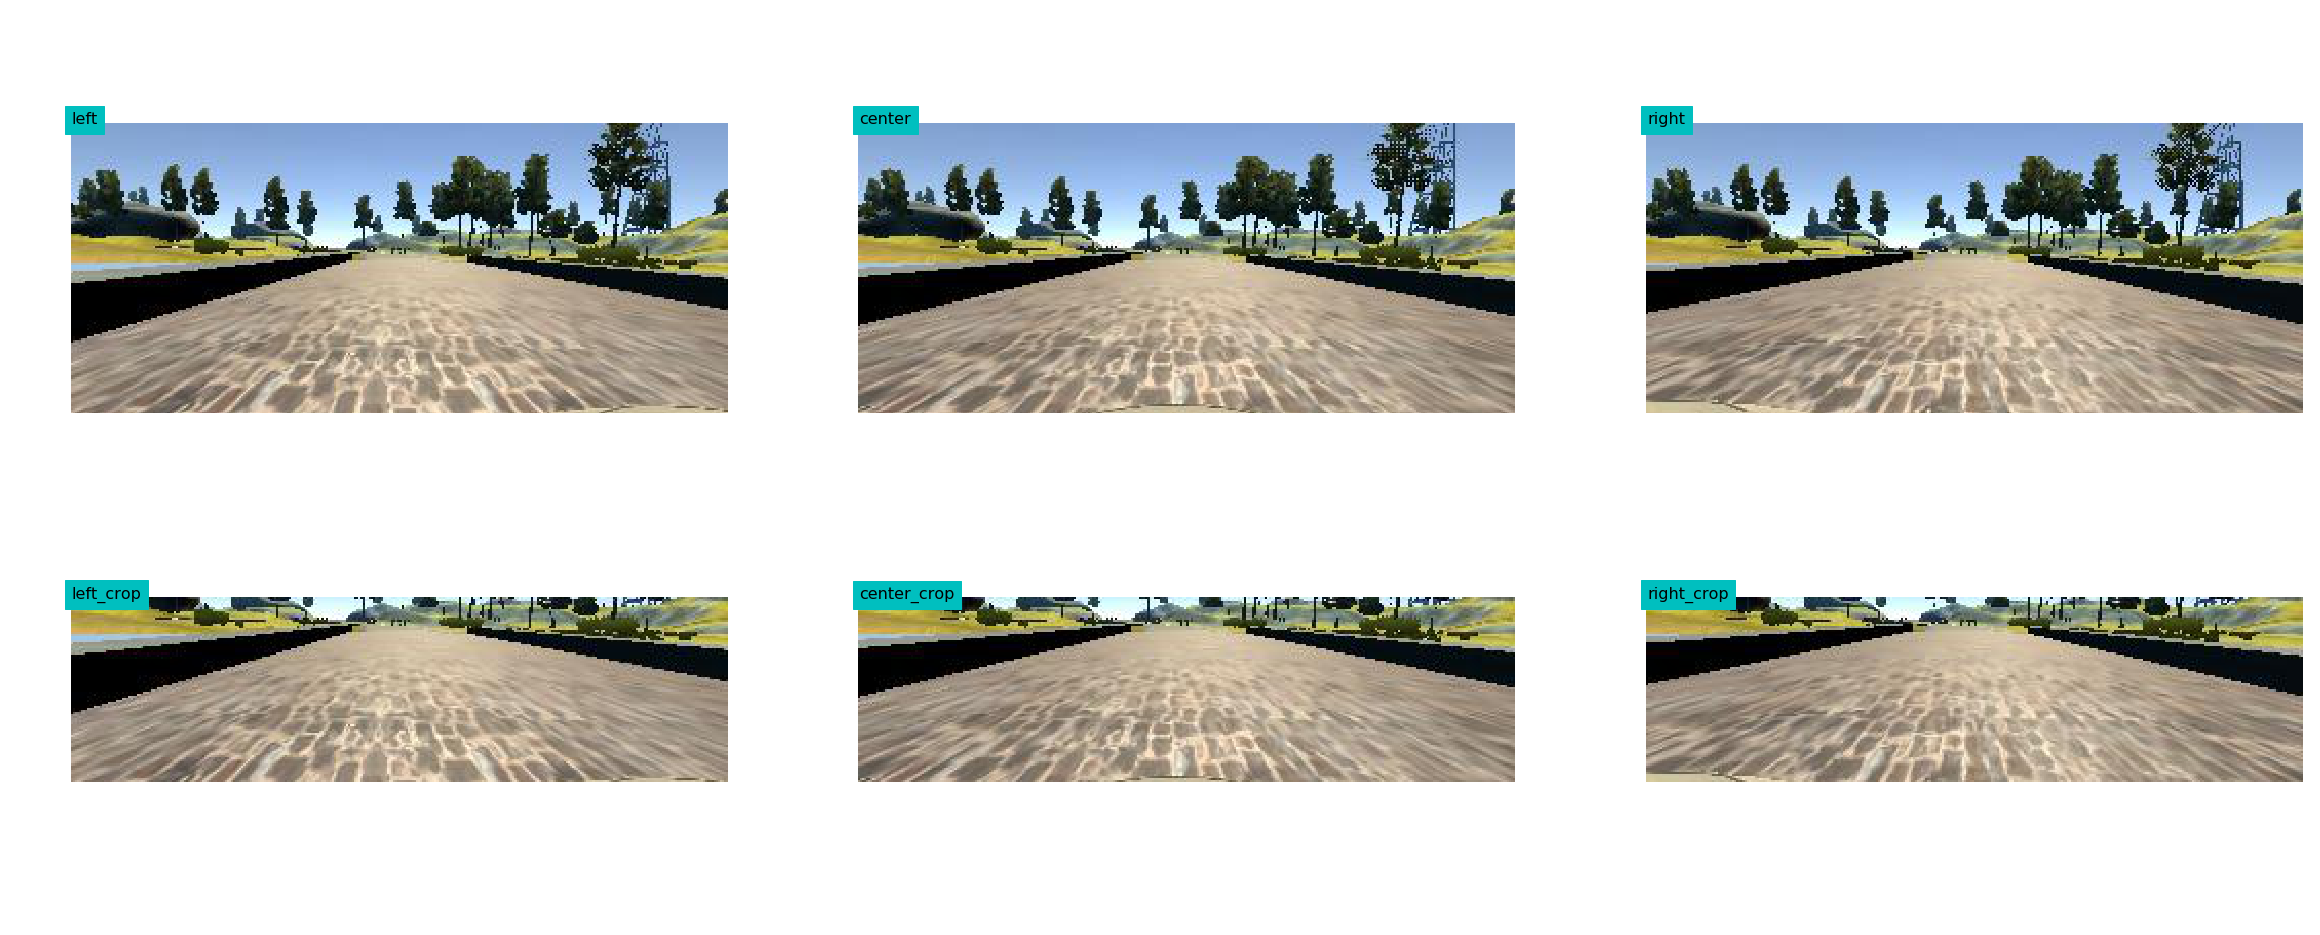

In [14]:
view_crop_img(0)

### Data augmentation

Note that the training data given is very limited and skewed (more positive angle than negative one), this shows an indication that we need to augment training data. The following steps can be employ to generate more data

#### Flip image
Notice that data is skewed (more positive than negative). One can flip image horizontally + flip sign of steering angle this can help to solve the skewness in training data

#### Multiple camera
As suggested from the project page
<center>
<img src="./assets/carnd-using-multiple-cameras.png" width="480">
</center>
formally :
* if we use left-camera steering_left = steering_center + correction
* if we use right-camera steering_right = steering_center - correction
    
where correction > 0 is a tunning parameters. 

Since we have a lot of sample with zero steering angle, we will randomly sub-sampled zero-steering angle by using left/right image

* if steering_center in [-eps, eps] than we randomly select with probability 1/3 between left/center or right image
* else
    * steering_center >  eps: i.e turning right we random select with probability 1/2 between center & left image
    * steering_center < -eps: i.e turning left we random select with probability 1/2 between center & right image

This helps us to expand the range of steering_angle and sub-sample zero-steering angle.

#### Random brightness
Since the images from track one are quite bright, we randomly changing the brightness so it can work on other track where images might be darker.

In [29]:
def random_flip(img, steering):
    if np.random.randint(2) == 0:
        return img, steering
    else:
        return np.fliplr(img), -steering

def read_img(lcr, img_left, img_center, img_right, steering, correction):
    if (lcr == 0):
        return mpimg.imread(img_left), steering + correction
    elif (lcr == 1):
        return mpimg.imread(img_center), steering
    else:
        return mpimg.imread(img_right), steering - correction

def multiple_camera(img_left, img_center, img_right, steering, correction, eps):
    if abs(steering) <= eps:
        lcr = np.random.randint(3)        
    elif steering > eps:
        lcr = np.random.randint(2) # left or center
    else:
        lcr = np.random.randint(2) + 1 # center or right
    
    return read_img(lcr, img_left, img_center, img_right, steering, correction)

def random_brightness(img):
    # convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # randomly adjust brightness
    hsv[:,:,2] = np.random.uniform(0.3, 1.0) * hsv[:,:,2]
    
    # convert back to RGB
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def crop_resize(img, target_size):
    cropped = cv2.resize(image[50:140,:], target_size)
    
def get_aug_data(img_left, img_center, img_right, steering, correction, eps):
    # read from multiple camera
    img, steering = multiple_camera(img_left, img_center, img_right, steering, correction, eps)
    
    # random flip
    #img, steering = random_flip(img, steering)
    
    # random brightness
    img = random_brightness(img)
    
    return img, steering

Let's visualize some random image side-by-side with original data

In [30]:
CORRECTION = np.arctan(1./20.) * 180. / np.pi
EPS = 0.1

def visualize_aug(row_idx, dataset = driving_log, correction = CORRECTION, eps = EPS, figsize = (20,3)):
    img_left, img_center, img_right, steering = dataset[['left', 'center','right', 'steering']].values[row_idx]
    img_aug, steering_aug = get_aug_data(img_left, img_center, img_right, steering, correction, eps)
    fig, axes = plt.subplots(figsize= figsize, nrows=1, ncols=4, sharey=True, sharex=True)
    
    imgs = [mpimg.imread(img_left), mpimg.imread(img_center), mpimg.imread(img_right), img_aug]
    labels = ['left', 'center-steering={:.3f}'.format(steering), 'right', 'sample-steering={:.3f}'.format(steering_aug)]
    
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax=ax)

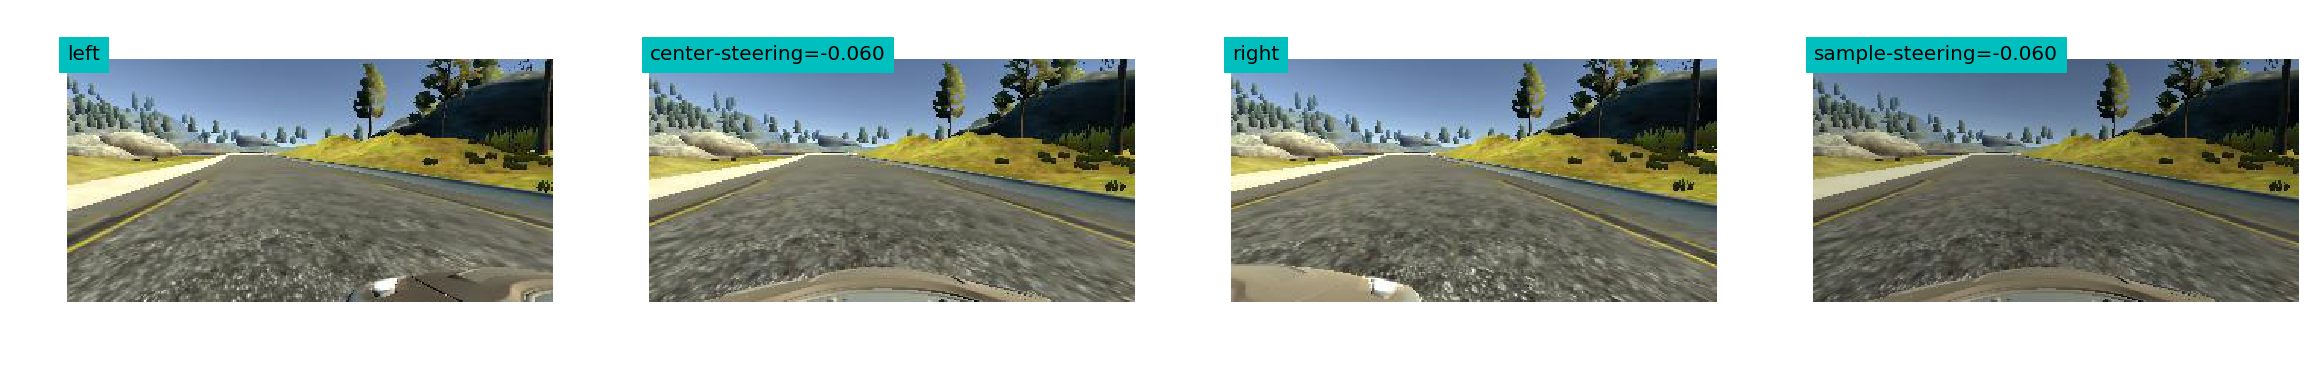

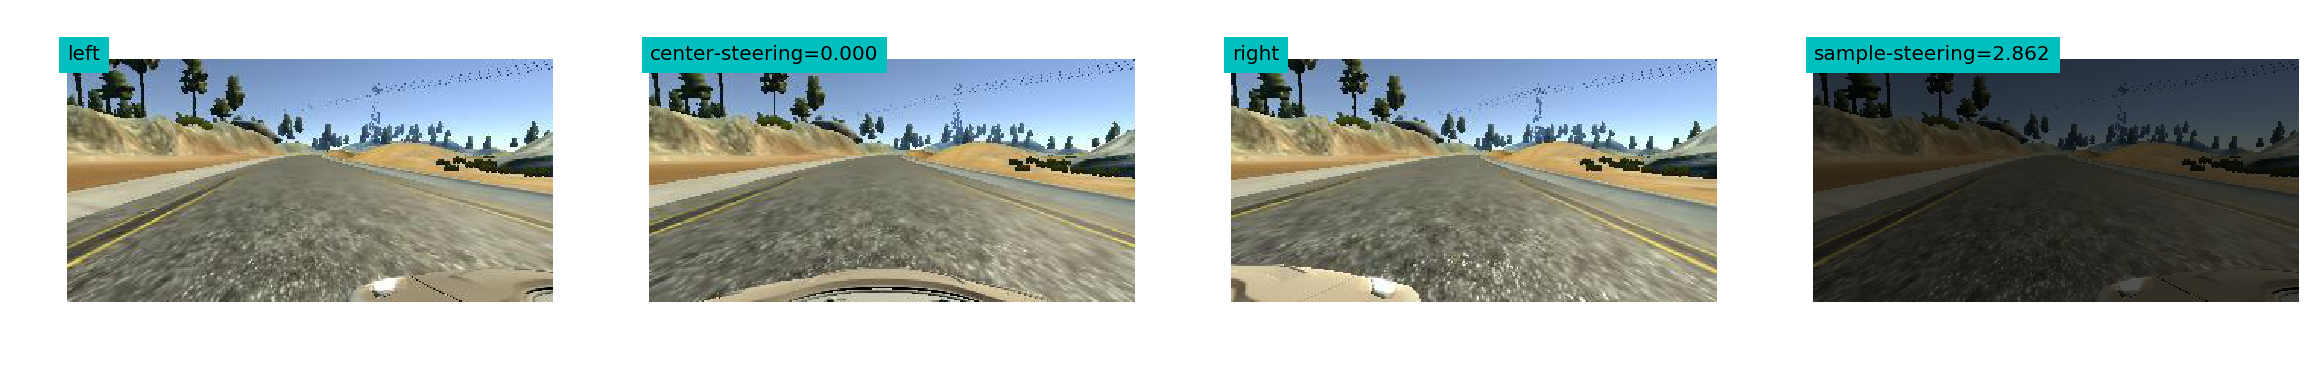

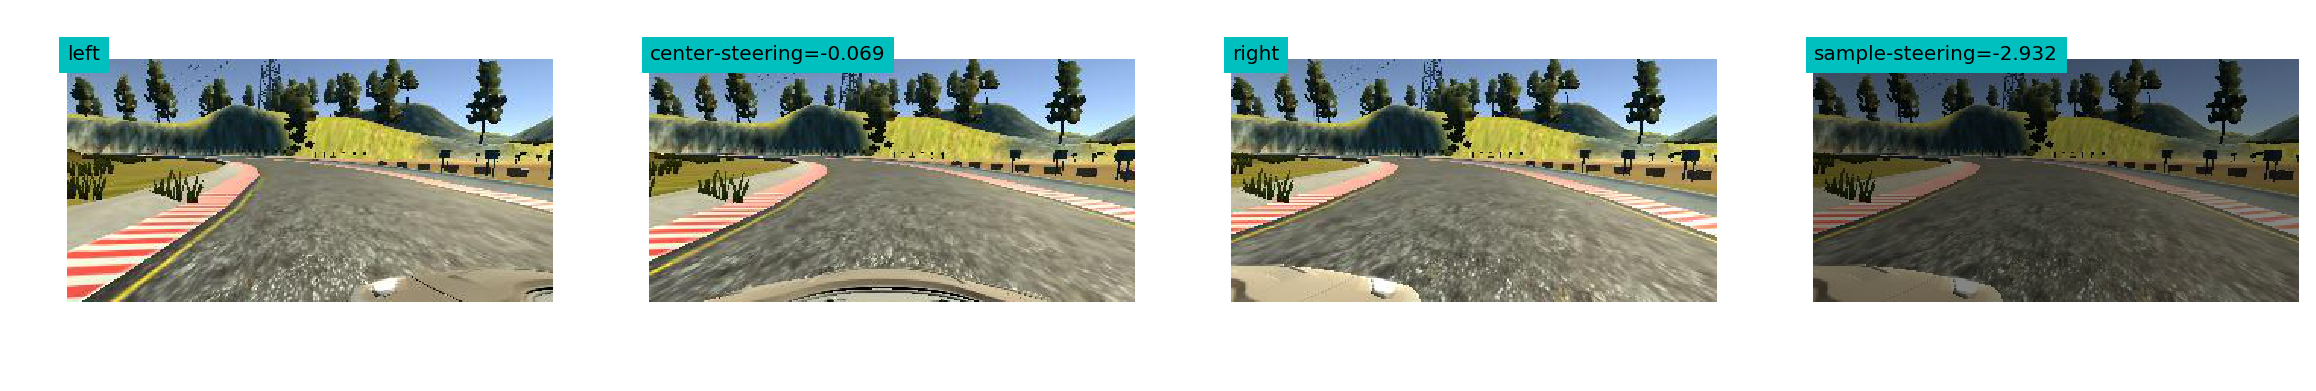

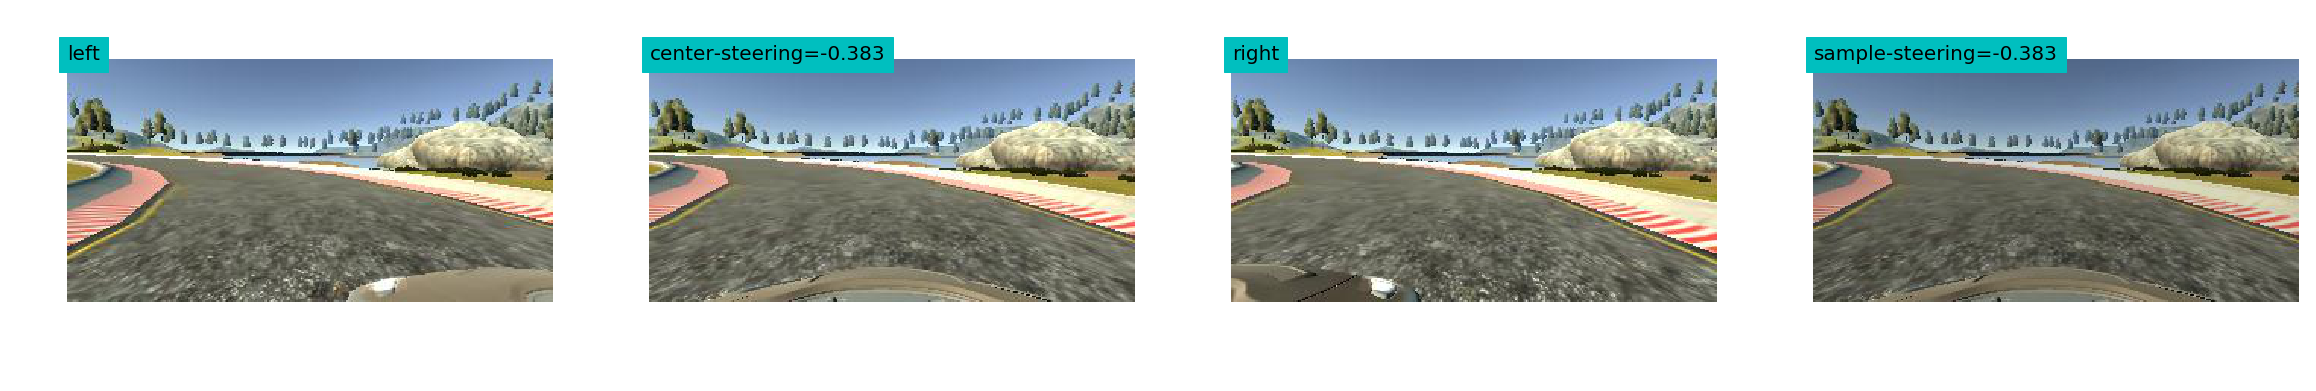

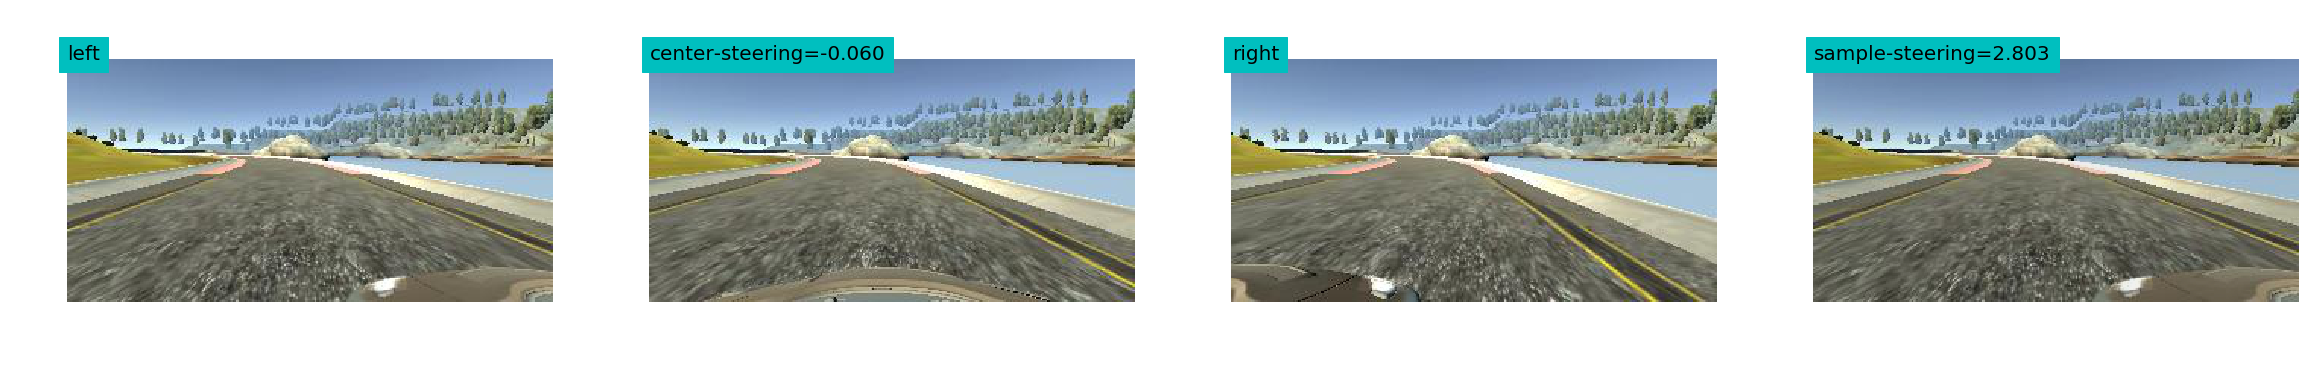

In [32]:
for i in range(5):
    visualize_aug(np.random.randint(driving_log.shape[0]))